In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split

from seiz_eeg.dataset import EEGDataset

# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [3]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "./data"  # Change this to your actual data path

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

# Split the dataset by the 'patient' column
patients = clips_tr['signals_path'].unique()
train_patients, val_patients = train_test_split(patients, test_size=0.2, random_state=42)

# Create training and validation datasets
train_clips = clips_tr[clips_tr['signals_path'].isin(train_patients)]
val_clips = clips_tr[clips_tr['signals_path'].isin(val_patients)]

## Loading the signals

For convenience, the `EEGDataset class` provides functionality for loading each segment and its label as `numpy` arrays.

You can provide an optional `signal_transform` function to preprocess the signals. In the example below, we have two bandpass filtering functions, which extract frequencies between 0.5Hz and 30Hz which are used in seizure analysis literature:

The `EEGDataset` class also allows to load all data in memory, instead of reading it from disk at every iteration. If your compute allows it, you can use `prefetch=True`.

In [4]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

## Compatibility with PyTorch

The `EEGDataset` class is compatible with [pytorch datasets and dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allow you to load batched data.

In [5]:
# Dependences
import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm

In [6]:
def seed_everything(seed: int):
    # Python random module
    random.seed(seed)
    # Numpy random module
    np.random.seed(seed)
    # Torch random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Set PYTHONHASHSEED environment variable for hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cudnn (may slow down your training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1)

In [7]:
train_dataset = EEGDataset(
        train_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=time_filtering,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

val_dataset = EEGDataset(
        val_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=time_filtering,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

loader_tr = DataLoader(
        dataset=train_dataset,
        shuffle=True,
        batch_size=64,
    )

loader_val = DataLoader(
        dataset=val_dataset,
        shuffle=True,
        batch_size=64,
    )

In [8]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [9]:
adj = np.genfromtxt('./data/distances_3d.csv', skip_header=1, delimiter=',')[:, -1].reshape(19,19)
adj = torch.tensor(adj, dtype=torch.float32).to(device).unsqueeze(0)
print(adj.shape)

torch.Size([1, 19, 19])


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChebConv(nn.Module):
    def __init__(self, in_channels, out_channels, K, adj):
        super().__init__()
        self.K = K
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.adj = adj  # [V, V]
        self.register_buffer('laplacian', ChebConv.normalized_laplacian(adj))
        self.linear = nn.Linear(in_channels * K, out_channels)

    @staticmethod
    def normalized_laplacian(adj):
        # Compute normalized Laplacian
        D = torch.diag(adj.sum(1))
        D_inv_sqrt = torch.diag(1.0 / torch.sqrt(adj.sum(1) + 1e-5))
        L = torch.eye(adj.size(0), device=adj.device) - D_inv_sqrt @ adj @ D_inv_sqrt
        return L

    def chebyshev_polynomials(self, x):
        # x: [N, T, V, in_channels]
        L = self.laplacian
        Tx_0 = x
        Tx_1 = torch.einsum('vw,ntwc->ntwc', L, x)
        T_list = [Tx_0, Tx_1]
        for k in range(2, self.K):
            Tx_k = 2 * torch.einsum('vw,ntwc->ntwc', L, T_list[-1]) - T_list[-2]
            T_list.append(Tx_k)
        return T_list

    def forward(self, x):
        # x: [N, T, V, in_channels]
        cheb_polys = self.chebyshev_polynomials(x)
        out = torch.cat(cheb_polys, dim=-1)  # [N, T, V, in_channels*K]
        out = self.linear(out)  # [N, T, V, out_channels]
        return out

In [11]:
class ChebNetEEG(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, K, adj):
        super().__init__()
        self.cheb1 = ChebConv(in_channels, hidden_channels, K, adj)
        self.cheb2 = ChebConv(hidden_channels, hidden_channels, K, adj)
        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        # x: [N, T, V] -> [N, T, V, 1]
        x = x.unsqueeze(-1)
        x = F.relu(self.cheb1(x))
        x = F.relu(self.cheb2(x))
        x = x.mean(dim=1)  # Temporal average: [N, V, hidden]
        x = x.mean(dim=1)  # Spatial average: [N, hidden]
        x = self.fc(x)
        return x

In [12]:
K = 3  # Chebyshev polynomial order
hidden_channels = 32
model = ChebNetEEG(
    in_channels=1,  # since you use fft_filtering, adjust if needed
    hidden_channels=hidden_channels,
    out_channels=1,  # binary classification
    K=K,
    adj=adj.squeeze(0),  # [V, V]
).to(device)
class_weight =4
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight]).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [18]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of model parameters: {num_params}")

Number of model parameters: 3265


In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Training loop
num_epochs = 25
train_losses = []
val_losses = []
val_f1_scores = []
val_precision_scores = []
val_recall_scores = []
val_best_thresholds = []

# check if if the model is using GPU
if torch.cuda.is_available():
    print("Model is using GPU")
else:
    print("Model is using CPU")

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in loader_tr:
        # Move data to GPU (if available)
        x_batch = x_batch.float().to(device)  # [batch_size, seq_len, input_dim]
        y_batch = y_batch.float().unsqueeze(1).to(device)  # [batch_size, 1]

        # Forward pass
        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader_tr)
    train_losses.append(avg_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for x_val, y_val in loader_val:
            # Move data to GPU (if available)
            x_val = x_val.float().to(device)  # [batch_size, seq_len, input_dim]
            y_val = y_val.float().unsqueeze(1).to(device)  # [batch_size, 1]

            # Forward pass
            val_logits = model(x_val)
            val_probs = torch.sigmoid(val_logits)  # Apply sigmoid for binary classification
            val_preds = (val_probs > 0.5).int()  # Convert probabilities to binary predictions

            # Collect all labels and predictions
            all_labels.extend(y_val.cpu().numpy())
            all_preds.extend(val_preds.cpu().numpy())

            # Compute validation loss
            val_loss = criterion(val_logits, y_val)
            val_running_loss += val_loss.item()

    avg_val_loss = val_running_loss / len(loader_val)
    val_losses.append(avg_val_loss)

    # Compute metrics for validation data
    all_labels = np.array(all_labels).flatten()
    all_preds = np.array(all_preds).flatten()
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    val_precision = precision_score(all_labels, all_preds, average='macro')
    val_recall = recall_score(all_labels, all_preds, average='macro')
    val_f1_scores.append(val_f1)
    val_precision_scores.append(val_precision)
    val_recall_scores.append(val_recall)
    print(val_f1)

Model is using GPU


Training:   4%|███████▎                                                                                                                                                                               | 1/25 [00:13<05:18, 13.25s/it]

0.5849072666719408


Training:   8%|██████████████▋                                                                                                                                                                        | 2/25 [00:25<04:56, 12.88s/it]

0.6246744814272123


Training:  12%|█████████████████████▉                                                                                                                                                                 | 3/25 [00:38<04:41, 12.78s/it]

0.4925934056667825


Training:  16%|█████████████████████████████▎                                                                                                                                                         | 4/25 [00:51<04:27, 12.72s/it]

0.6232118825735602


Training:  20%|████████████████████████████████████▌                                                                                                                                                  | 5/25 [01:03<04:14, 12.73s/it]

0.649065895965383


Training:  24%|███████████████████████████████████████████▉                                                                                                                                           | 6/25 [01:16<04:01, 12.69s/it]

0.6202085645019642


Training:  28%|███████████████████████████████████████████████████▏                                                                                                                                   | 7/25 [01:29<03:47, 12.66s/it]

0.617210836618654


Training:  32%|██████████████████████████████████████████████████████████▌                                                                                                                            | 8/25 [01:41<03:35, 12.66s/it]

0.5703716216216217


Training:  36%|█████████████████████████████████████████████████████████████████▉                                                                                                                     | 9/25 [01:59<03:47, 14.22s/it]

0.5988672983656551


Training:  40%|████████████████████████████████████████████████████████████████████████▊                                                                                                             | 10/25 [02:26<04:31, 18.12s/it]

0.6785129129301617


Training:  44%|████████████████████████████████████████████████████████████████████████████████                                                                                                      | 11/25 [03:38<08:06, 34.75s/it]

0.589171974522293


Training:  48%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 12/25 [04:58<10:31, 48.55s/it]

0.6906633778854226


Training:  52%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 13/25 [06:25<12:01, 60.13s/it]

0.6549856937987988


Training:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 14/25 [07:52<12:29, 68.17s/it]

0.6414284922073914


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 15/25 [09:13<12:01, 72.17s/it]

0.5752588671784572


Training:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 16/25 [10:41<11:32, 76.91s/it]

0.5479123340265557


Training:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 17/25 [12:09<10:40, 80.11s/it]

0.5784248882424848


Training:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 18/25 [13:15<08:52, 76.06s/it]

0.6465973163162726


Training:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 19/25 [14:41<07:54, 79.02s/it]

0.58750942177237


Training:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 20/25 [14:59<05:02, 60.58s/it]

0.6505339609600181


Training:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 21/25 [15:12<03:04, 46.20s/it]

0.6727030020733336


Training:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 22/25 [15:25<01:48, 36.25s/it]

0.6190318900291502


Training:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 23/25 [15:37<00:58, 29.20s/it]

0.6298307011357388


Training:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 24/25 [15:50<00:24, 24.19s/it]

0.6398788199370056


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [16:03<00:00, 38.52s/it]

0.6131652441729961


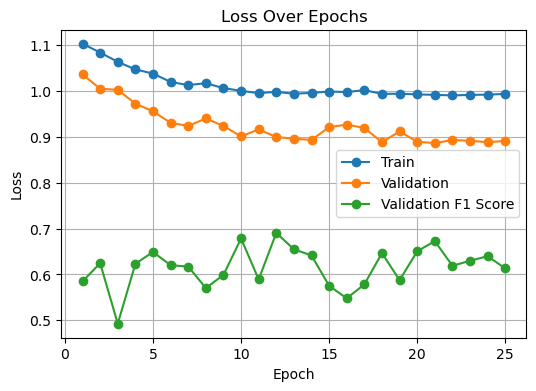

In [14]:
# Plot the training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_f1_scores, marker="o")
#plt.plot(range(1, num_epochs + 1), val_precision_scores, marker="o")
#plt.plot(range(1, num_epochs + 1), val_recall_scores, marker="o")
plt.title("Loss Over Epochs")
plt.legend(["Train", "Validation", "Validation F1 Score", "Validation Precision", "Validation Recall"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
from evaluation import evaluate

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

class_weight = 4
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight]).to(device))

# check if the it using gpu
if torch.cuda.is_available():
    print("Using GPU for evaluation")
else:
    print("Using CPU for evaluation")

evaluate(
    ChebNetEEG,
    clips_tr,
    signals_root=DATA_ROOT / "train",
    num_epochs=15,
    learning_rate=1e-3,
    model_args={
        "out_channels": 1,
        "in_channels": 1,
        "hidden_channels": 32,  
        "K": 3,                
        "adj": adj.squeeze(0),  # Use the correct argument name
    },
    criterion=criterion,
    signal_transform=time_filtering,
    batch_size=256,  # Reduce batch size to avoid OOM
    prefetch=True, # Set to False if you still get OOM
)

Using GPU for evaluation
Fold 1/5
Fold 1 F1 Score: 0.6426
Fold 2/5
Fold 2 F1 Score: 0.5855
Fold 3/5
Fold 3 F1 Score: 0.6187
Fold 4/5
Fold 4 F1 Score: 0.5828
Fold 5/5
Fold 5 F1 Score: 0.5679
Cross-Validation Average F1 Score: 0.5995
Cross-Validation F1 Score Standard Deviation: 0.0272


(0.5995227164074473, 0.027207378789669636)

: 

# Submission

In [ ]:
test_clips = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

In [ ]:
# Create test dataset
dataset_te = EEGDataset(
    test_clips,  # Your test clips variable
    signals_root=DATA_ROOT
    / "test",  # Update this path if your test signals are stored elsewhere
    signal_transform=fft_filtering,  # You can change or remove the signal_transform as needed
    prefetch=True,  # Set to False if prefetching causes memory issues on your compute environment
    return_id=True,  # Return the id of each sample instead of the label
)

# Create DataLoader for the test dataset
loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)

In [ ]:
# Generate the submission file for Kaggle

# Set the model to evaluation mode
model.eval()

# Lists to store sample IDs and predictions
all_predictions = []
all_ids = []

# Disable gradient computation for inference
with torch.no_grad():
    for batch in loader_te:
        # Assume each batch returns a tuple (x_batch, sample_id)
        # If your dataset does not provide IDs, you can generate them based on the batch index.
        x_batch, x_ids = batch

        # Move the input data to the device (GPU or CPU)
        x_batch = x_batch.float().to(device)

        # Perform the forward pass to get the model's output logits
        logits = model(x_batch)

        # Convert logits to predictions.
        # For binary classification, threshold logits at 0 (adjust this if you use softmax or multi-class).
        predictions = (logits > 0).int().cpu().numpy()

        # Append predictions and corresponding IDs to the lists
        all_predictions.extend(predictions.flatten().tolist())
        all_ids.extend(list(x_ids))

# Create a DataFrame for Kaggle submission with the required format: "id,label"
submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})

# Save the DataFrame to a CSV file without an index
submission_df.to_csv("submission_seed1.csv", index=False)
print("Kaggle submission file generated: submission.csv")

Kaggle submission file generated: submission.csv
